In [44]:
# ==========================================
# 0. IMPORTS ET TÉLÉCHARGEMENTS
# ==========================================
import json
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.util import ngrams
from nltk import pos_tag, Text
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\A\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\A\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [45]:

# 1. PARAMÈTRES ET FILTRES

NOISE_WORDS = {
    'fox', 'news', 'digital', 'app', 'click', 'get', 'subscribe', 
    'image', 'getty', 'via', 'associated', 'press', 'report', 
    'contributed', 'advertisement', 'copyright', 'editor', 'video',
    'photo', 'available', 'illustration', 'january', 'tuesday', 'monday'
}

LEXICAL_CATEGORIES = {
    "violence": ["attack", "kill", "bomb", "strike", "shelling", "firing", "wounded", "casualty", "missile", "terror", "terrorist"],
    "victims": ["child", "children", "civilian", "woman", "man", "family", "orphan", "refugee", "patient", "innocent"],
    "responsibility": ["government", "army", "military", "forces", "idf", "hamas", "official", "president", "leader", "putin", "zelenskyy"],
    "emotion": ["fear", "panic", "trauma", "desperate", "shock", "horror", "sad", "grief", "angry", "harrowing"],
    "law_justice": ["invasion", "illegal", "occupation", "justice", "crime", "aggression", "war crime", "law"]
}




In [46]:
# 2. CHARGEMENT ET NETTOYAGE

def load_and_clean_corpus(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    articles = data["articles"] if isinstance(data, dict) and "articles" in data else data
    
    all_tokens = []
    for article in articles:
        text = article.get("content_lemmatized", article.get("content_clean", ""))
        tokens = word_tokenize(text.lower())
        cleaned = [t for t in tokens if t not in NOISE_WORDS and t.isalpha()]
        all_tokens.append(cleaned)
    return all_tokens, articles



In [47]:

# 3. ANALYSE LEXICALE 

def executer_analyse_master(tokens, articles, nom_conflit):
    print(f"\n\n{'#'*60}")
    print(f"### ANALYSE FINALE : {nom_conflit.upper()} ###")
    print(f"{'#'*60}")

    #  CONTEXTE ET SIMILARITÉ 
    flat_tokens = [t for doc in tokens for t in doc]
    t = Text(flat_tokens)
    print(f"\n[I] ANALYSE DU CONTEXTE ('civilian'):")
    t.concordance("civilian", lines=5)
    print("\nMots similaires à 'war' :")
    t.similar("war")

    #  DIVERSITÉ ET HAPAX 
    fdist = FreqDist(flat_tokens)
    nb_tokens = len(flat_tokens)
    nb_types = len(fdist.keys())
    print(f"\n[II] DIVERSITÉ LEXICALE")
    print(f"Tokens : {nb_tokens} | Types : {nb_types}")
    print(f"Richesse : {nb_types/nb_tokens:.4f}")
    print(f"Hapax : {len(fdist.hapaxes())}")
    
    plt.figure(figsize=(10, 3))
    fdist.plot(10, title=f"Top 10 Mots - {nom_conflit}")

    # . WORD CLOUD
    wc = WordCloud(width=800, height=400, background_color='white').generate(" ".join(flat_tokens))
    plt.figure(figsize=(10, 5))
    plt.imshow(wc)
    plt.axis('off')
    plt.title(f"Nuage de mots : {nom_conflit}")
    plt.show()

    #  N-GRAMS ET ADJECTIFS 
    print(f"\n[IV] MODÈLES STATISTIQUES ET POS-TAGGING")
    
    bigrams = list(ngrams(flat_tokens, 2))
    fdist_bi = FreqDist(bigrams)
    print("Top 5 Bigrammes (Probabilités MLE) :")
    for bg, count in fdist_bi.most_common(5):
        prob = count / flat_tokens.count(bg[0])
        print(f"P({bg[1]}|{bg[0]}) = {prob:.4f} ({count} fois)")

    tags = pos_tag(flat_tokens)
    adjectives = [word for word, tag in tags if tag == 'JJ']
    print(f"Top 5 Adjectifs : {Counter(adjectives).most_common(5)}")

    #  STATISTIQUES THÉMATIQUES 
    print(f"\n[V] POIDS THÉMATIQUES (pour 1000 mots)")
    for cat, words in LEXICAL_CATEGORIES.items():
        count = sum(flat_tokens.count(w) for w in words)
        score = (count / nb_tokens) * 1000 if nb_tokens > 0 else 0
        print(f"{cat:<15} : {score:.2f}")

    #  TYPE/TOKEN RATIO 
    ttr = len(set(flat_tokens)) / len(flat_tokens)
    print(f"\n[VI] Type/Token Ratio (TTR) : {ttr:.3f}")

    #  STOCKAGE POUR COMPARAISON 
    global tokens_ukraine_flat, tokens_gaza_flat
    if nom_conflit.lower() == "ukraine":
        tokens_ukraine_flat = flat_tokens
    elif nom_conflit.lower() == "gaza":
        tokens_gaza_flat = flat_tokens





############################################################
### ANALYSE FINALE : UKRAINE ###
############################################################

[I] ANALYSE DU CONTEXTE ('civilian'):
Displaying 5 of 58 matches:
war we not know many our child our civilian abduct kill three ukrainian teen e
e their feeling learn cop strategy civilian show irpin ukraine they continue f
er human right ohchr confirm least civilian kill injured ukraine since onset r
ce ohchr say believe actual figure civilian casualty considerably higher espec
ts sumy region amid claim numerous civilian casualty area like sumy people nea

Mots similaires à 'war' :
across conflict stand home invasion we western local desire yearslong
instability

[II] DIVERSITÉ LEXICALE
Tokens : 16184 | Types : 3581
Richesse : 0.2213
Hapax : 1846


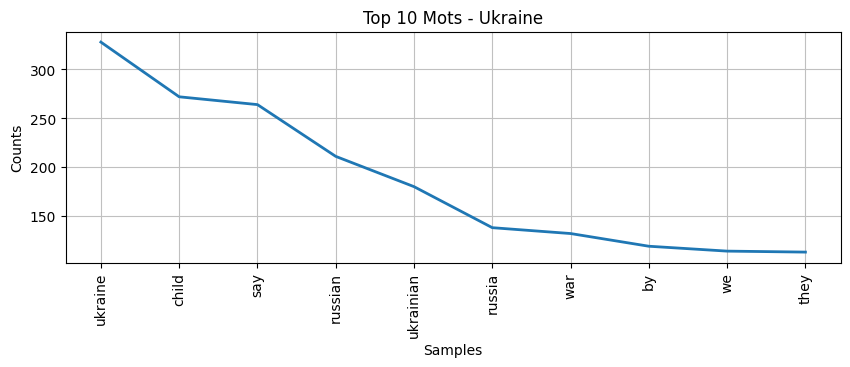

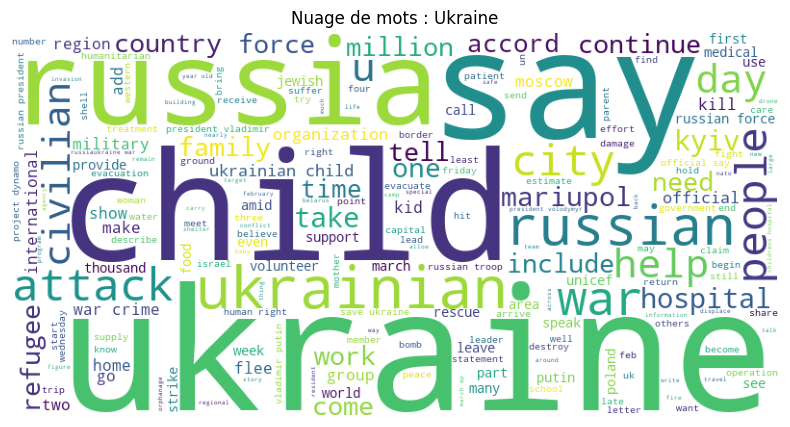


[IV] MODÈLES STATISTIQUES ET POS-TAGGING
Top 5 Bigrammes (Probabilités MLE) :
P(child|ukrainian) = 0.1889 (34 fois)
P(crime|war) = 0.2121 (28 fois)
P(russian|by) = 0.2269 (27 fois)
P(force|russian) = 0.1280 (27 fois)
P(vladimir|president) = 0.3559 (21 fois)
Top 5 Adjectifs : [('ukraine', 286), ('russian', 208), ('ukrainian', 180), ('child', 56), ('u', 53)]

[V] POIDS THÉMATIQUES (pour 1000 mots)
violence        : 12.48
victims         : 29.60
responsibility  : 16.07
emotion         : 1.30
law_justice     : 5.87

[VI] Type/Token Ratio (TTR) : 0.221


############################################################
### ANALYSE FINALE : GAZA ###
############################################################

[I] ANALYSE DU CONTEXTE ('civilian'):
Displaying 5 of 103 matches:
ducted massacre slaughter innocent civilian motorcycle hagari pointed bullet h
 facility hamas also accused using civilian shield hide among population wear 
 shield hide among population wear civilian clothing attack organ

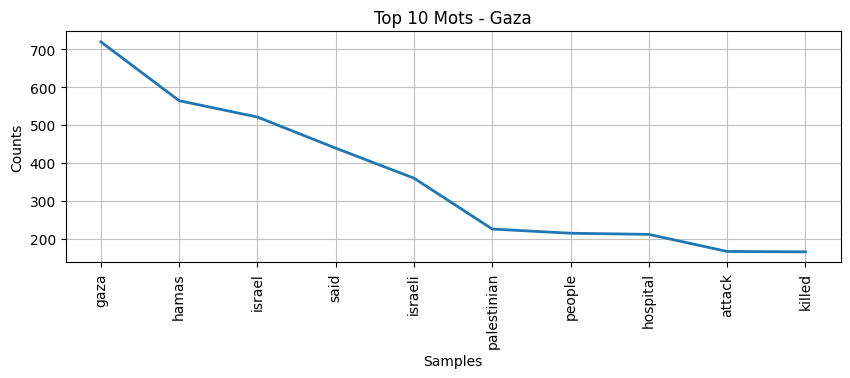

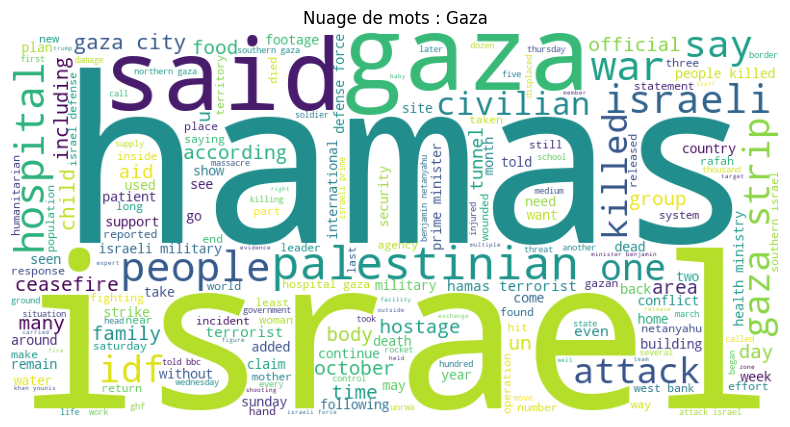


[IV] MODÈLES STATISTIQUES ET POS-TAGGING
Top 5 Bigrammes (Probabilités MLE) :
P(strip|gaza) = 0.1446 (104 fois)
P(city|gaza) = 0.1266 (91 fois)
P(terrorist|hamas) = 0.0957 (54 fois)
P(military|israeli) = 0.1444 (52 fois)
P(killed|people) = 0.2000 (43 fois)
Top 5 Adjectifs : [('israeli', 353), ('palestinian', 206), ('gaza', 184), ('israel', 167), ('hamas', 139)]

[V] POIDS THÉMATIQUES (pour 1000 mots)
violence        : 16.23
victims         : 13.06
responsibility  : 35.35
emotion         : 0.88
law_justice     : 2.59

[VI] Type/Token Ratio (TTR) : 0.186


In [49]:

# 4. CHARGEMENT DES CORPUS

tokens_u, art_u = load_and_clean_corpus("corpus_ukraine_clean.json")
tokens_g, art_g = load_and_clean_corpus("corpus_gaza_clean.json")


# 5. EXECUTION DES ANALYSES

executer_analyse_master(tokens_u, art_u, "Ukraine")
executer_analyse_master(tokens_g, art_g, "Gaza")



[II] DIVERSITÉ LEXICALE

Cette section mesure la variété lexicale du corpus, c’est-à-dire la richesse et la diversité du vocabulaire utilisé.

Tokens : 16184

Définition : nombre total de mots dans le corpus après nettoyage (ponctuation et mots bruyants retirés).

Ici, le corpus contient 16 184 mots.

Chaque occurrence d’un mot compte : par exemple, « war » répété 50 fois compte pour 50 tokens.

Types : 3581

Définition : nombre de mots uniques dans le corpus (chaque mot distinct est compté une seule fois).

Ici, il y a 3 581 mots différents.

Cela montre la diversité lexicale : plus le nombre de types est grand par rapport aux tokens, plus le vocabulaire est riche.

Richesse : 0.2213

Calcul : richesse = nb_types / nb_tokens

Ici : 3581 ÷ 16184 ≈ 0.2213

Interprétation : environ 22 % des mots sont uniques.

Plus ce ratio est élevé, plus le corpus est diversifié lexicalement.

Hapax : 1846

Définition : nombre de mots qui apparaissent une seule fois dans le corpus.

Ici, 1 846 mots sont des hapax.

Les hapax sont souvent des noms propres, termes spécifiques ou fautes de frappe.

Leur proportion permet de juger la rareté lexicale et la spécificité du corpus.

In [50]:

# 6. TF-IDF ET MOTS SPÉCIFIQUES

texts = [
    " ".join(tokens_ukraine_flat),
    " ".join(tokens_gaza_flat)
]

vectorizer = TfidfVectorizer(max_features=50)
tfidf_matrix = vectorizer.fit_transform(texts)
feature_names = vectorizer.get_feature_names_out()
print("\n[TF-IDF] Top mots importants :", feature_names)

unique_ukraine = set(tokens_ukraine_flat) - set(tokens_gaza_flat)
unique_gaza    = set(tokens_gaza_flat) - set(tokens_ukraine_flat)
print("\nMots spécifiques Ukraine (extrait):", list(unique_ukraine)[:20])
print("Mots spécifiques Gaza (extrait)   :", list(unique_gaza)[:20])




[TF-IDF] Top mots importants : ['aid' 'also' 'area' 'attack' 'by' 'ceasefire' 'child' 'city' 'civilian'
 'could' 'day' 'family' 'food' 'force' 'gaza' 'group' 'hamas' 'health'
 'hospital' 'hostage' 'idf' 'international' 'israel' 'israeli' 'killed'
 'many' 'military' 'october' 'official' 'one' 'palestinian' 'people'
 'russia' 'russian' 'said' 'say' 'since' 'strike' 'strip' 'take'
 'terrorist' 'their' 'they' 'time' 'told' 'ukraine' 'ukrainian' 'war' 'we'
 'would']

Mots spécifiques Ukraine (extrait): ['alexei', 'bear', 'conscript', 'candy', 'sergiy', 'outlaw', 'spotlight', 'madison', 'awatchdogreport', 'ayesha', 'opts', 'taube', 'paint', 'abundant', 'altogether', 'cruise', 'hood', 'bearing', 'deprave', 'performed']
Mots spécifiques Gaza (extrait)   : ['lianne', 'gray', 'fired', 'aclaim', 'dancing', 'targeting', 'married', 'aircampaign', 'increasing', 'possibly', 'vicinity', 'burn', 'halted', 'potomac', 'mcneil', 'plea', 'performance', 'palestiniansfrom', 'inaccurate', 'allowed']


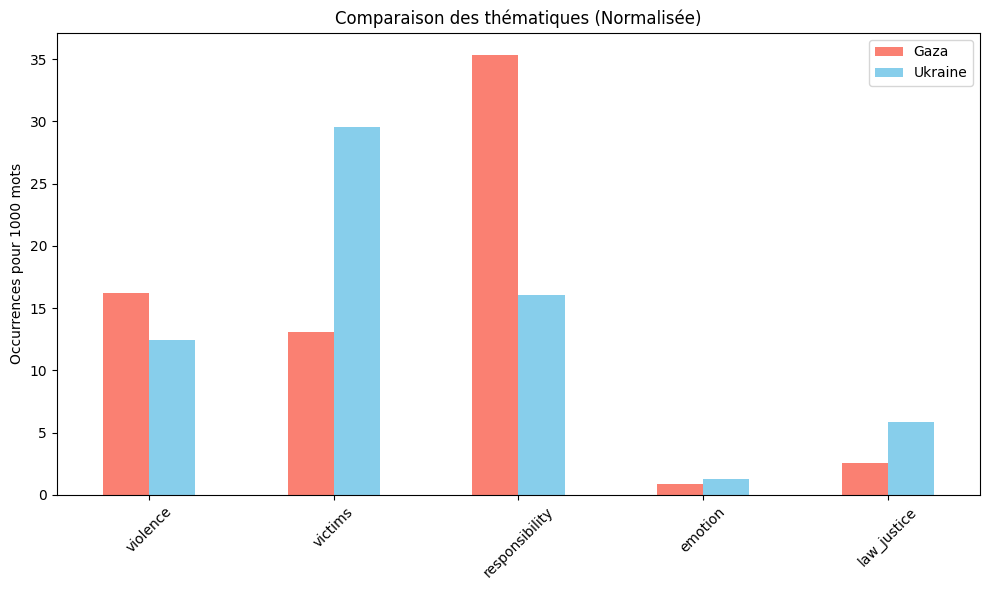

In [51]:
# ==========================================
# 7. COMPARAISON GRAPHIQUE DES THÉMATIQUES
# ==========================================
stats_ukraine = [sum(tokens_ukraine_flat.count(w) for w in words)/len(tokens_ukraine_flat)*1000 for words in LEXICAL_CATEGORIES.values()]
stats_gaza    = [sum(tokens_gaza_flat.count(w) for w in words)/len(tokens_gaza_flat)*1000 for words in LEXICAL_CATEGORIES.values()]

df_stats = pd.DataFrame({'Gaza': stats_gaza, 'Ukraine': stats_ukraine}, index=LEXICAL_CATEGORIES.keys())
df_stats.plot(kind='bar', figsize=(10, 6), color=['salmon', 'skyblue'])
plt.title("Comparaison des thématiques (Normalisée)")
plt.ylabel("Occurrences pour 1000 mots")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("comparaison_thematique.png")
plt.show()